# TP 4 - Machine Learning et Cybersécurité

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions
import foolbox

# Chargement de l'image pour l'exercice 1
image_path = "./img/Grosser_Panda.JPG"
img = Image.open(image_path)

# Convertir l'image en tableau numpy
img_array = np.array(img)

# Dimensions de l'image
height, width, channels = img_array.shape

2023-12-31 13:53:31.293155: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-31 13:53:31.323626: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-31 13:53:31.323652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-31 13:53:31.324325: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-31 13:53:31.328707: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-31 13:53:31.329029: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Exercice 1:

### Question 1

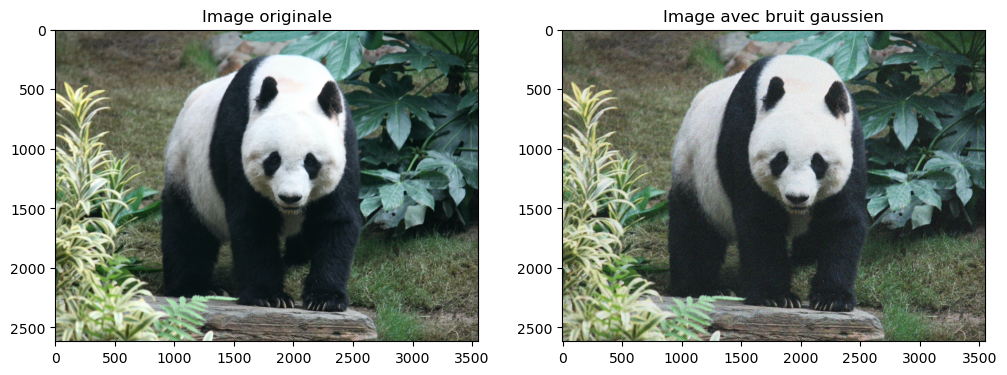

In [2]:
# Générer du bruit gaussien
mean = 0
std_dev = 50  # Choisir l'écart-type du bruit gaussien en fonction de l'effet désiré
gaussian_noise = np.random.normal(mean, std_dev, (height, width, channels))

# Ajouter le bruit à l'image
noisy_img_array = img_array + gaussian_noise

# Convertir les valeurs à l'échelle [0, 255]
noisy_img_array = np.clip(noisy_img_array, 0, 255).astype(np.uint8)

# Créer une nouvelle image à partir du tableau modifié
noisy_img = Image.fromarray(noisy_img_array)

# Sauvegarder l'image avec bruit gaussien
noisy_img.save("./img/image_avec_bruit_gaussien.jpg")

# Afficher l'image originale et l'image avec bruit
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Image originale")

plt.subplot(1, 2, 2)
plt.imshow(noisy_img)
plt.title("Image avec bruit gaussien")

plt.show()

### Question 2

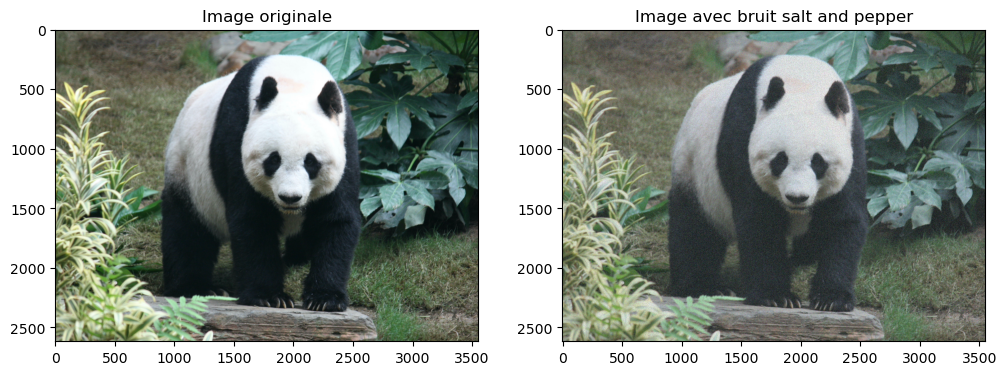

In [3]:
# Probabilité de bruit "salt and pepper" ajustée (moins de bruit)
salt_and_pepper_prob = 0.5

# Générer un masque de pixels à perturber
salt_and_pepper_mask = np.random.rand(height, width) < salt_and_pepper_prob

# Générer des valeurs de bruit pour les pixels perturbés
noise_values = np.random.randint(0, 256, (height, width, channels))

# Ajouter le bruit aux pixels perturbés
img_array[salt_and_pepper_mask] = (img_array[salt_and_pepper_mask] * 0.5) + (noise_values[salt_and_pepper_mask] * 0.5)

# Sauvegarder l'image avec bruit "salt and pepper"
noisy_img.save("./img/image_avec_bruit_salt_and_pepper.jpg")

# Afficher l'image originale et l'image avec bruit
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Image originale")

plt.subplot(1, 2, 2)
plt.imshow(img_array.astype(np.uint8))
plt.title("Image avec bruit salt and pepper")

plt.show()

### Question 3 

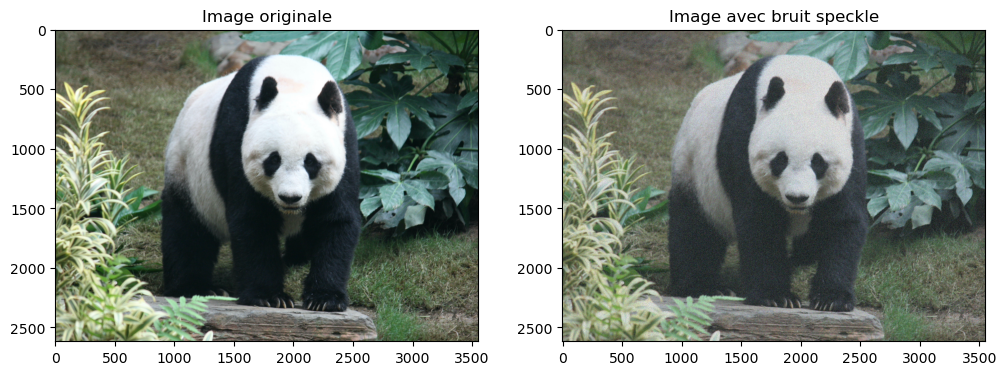

In [4]:
# Écart-type du bruit speckle (ajuste selon le niveau de bruit désiré)
speckle_std_dev = 0.1

# Générer du bruit speckle
speckle_noise = np.random.normal(1, speckle_std_dev, (height, width, channels))

# Ajouter le bruit speckle à l'image
speckled_img_array = img_array * speckle_noise

# Convertir les valeurs à l'échelle [0, 255]
speckled_img_array = np.clip(speckled_img_array, 0, 255).astype(np.uint8)

# Créer une nouvelle image à partir du tableau modifié
speckled_img = Image.fromarray(speckled_img_array)

# Sauvegarder l'image avec bruit speckle
speckled_img.save("./img/image_avec_bruit_speckle.jpg")

# Afficher l'image originale et l'image avec bruit speckle
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Image originale")

plt.subplot(1, 2, 2)
plt.imshow(speckled_img)
plt.title("Image avec bruit speckle")

plt.show()

### Question 4 

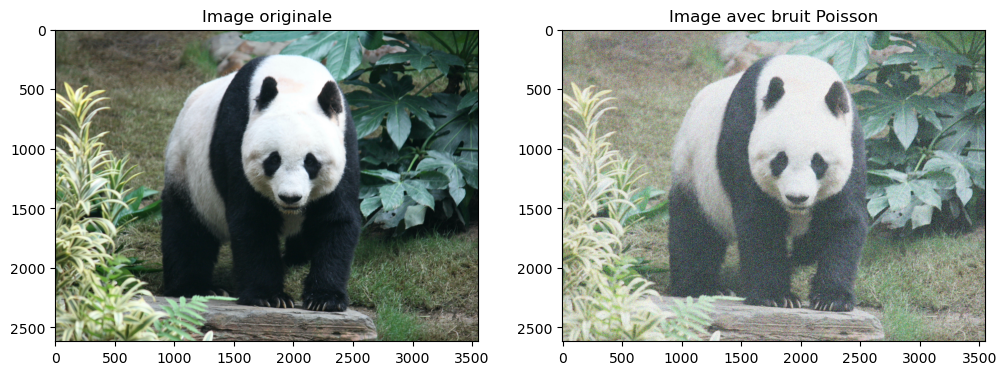

In [5]:
# Dimensions de l'image
height, width, channels = img_array.shape

# Générer du bruit Poisson
poisson_noise = np.random.poisson(img_array / 255.0) * 255.0

# Ajouter le bruit Poisson à l'image
poisson_img_array = img_array + poisson_noise

# Convertir les valeurs à l'échelle [0, 255]
poisson_img_array = np.clip(poisson_img_array, 0, 255).astype(np.uint8)

# Créer une nouvelle image à partir du tableau modifié
poisson_img = Image.fromarray(poisson_img_array)

# Sauvegarder l'image avec bruit Poisson
poisson_img.save("./img/image_avec_bruit_poisson.jpg")

# Afficher l'image originale et l'image avec bruit Poisson
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Image originale")

plt.subplot(1, 2, 2)
plt.imshow(poisson_img)
plt.title("Image avec bruit Poisson")

plt.show()

### Question 5 

1/1 [==============================] - 0s 492ms/step


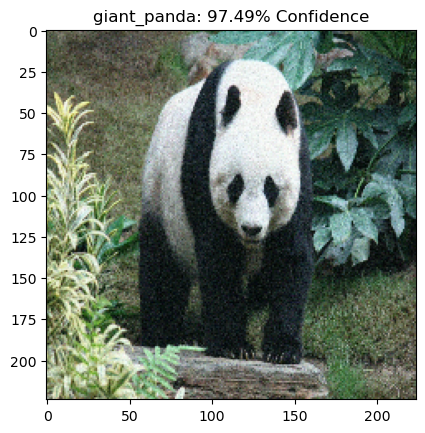

1/1 [==============================] - 0s 32ms/step


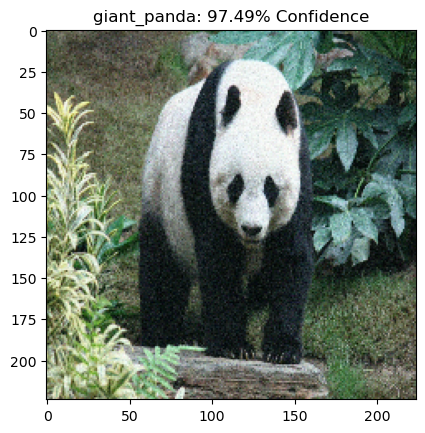

1/1 [==============================] - 0s 30ms/step


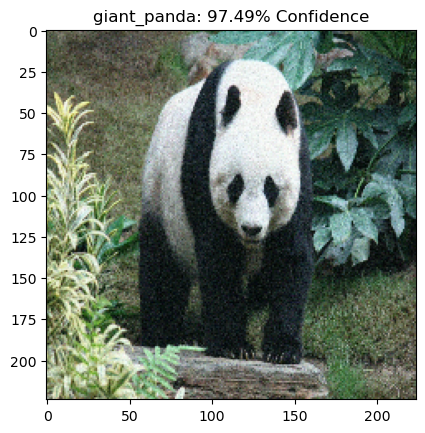

1/1 [==============================] - 0s 30ms/step


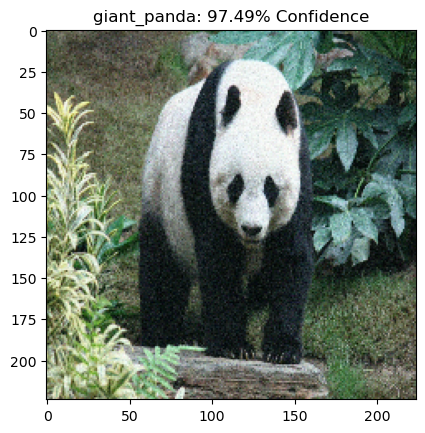

In [6]:
# Fonction de prétraitement spécifique à MobileNetV2
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image

# Fonction pour obtenir l'étiquette ImageNet prédite
def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

# Charger le modèle MobileNetV2 pré-entraîné sur ImageNet
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
pretrained_model.trainable = False

# Liste des noms de fichiers des images avec bruit
image_files = [
    "./img/image_avec_bruit_gaussien.jpg",
    "./img/image_avec_bruit_salt_and_pepper.jpg",
    "./img/image_avec_bruit_speckle.jpg",
    "./img/image_avec_bruit_poisson.jpg"
]

# Boucle pour tester chaque image
for image_file in image_files:
    # Charger l'image
    image_path = tf.keras.utils.get_file('demo.jpg', 'file:' + image_file)
    image_raw = tf.io.read_file(image_path)
    image = tf.image.decode_image(image_raw)
    image = preprocess(image)

    # Prédire la classe de l'image
    image_probs = pretrained_model.predict(image)

    # Afficher l'image avec la prédiction
    plt.figure()
    plt.imshow(image[0] * 0.5 + 0.5)
    _, image_class, class_confidence = get_imagenet_label(image_probs)
    plt.title('{}: {:.2f}% Confidence'.format(image_class, class_confidence * 100))
    plt.show()

#### Préparation pour les exercices 2, 3 et 4

In [7]:
# Chargement de l'image
image_path = "./img/Grosser_Panda.JPG"
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)

# Charger le modèle MobileNetV2 pré-entraîné sur ImageNet
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
pretrained_model.trainable = False

# Fonction de prétraitement spécifique à MobileNetV2
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image

## Exercice 2

1/1 [==============================] - 0s 34ms/step


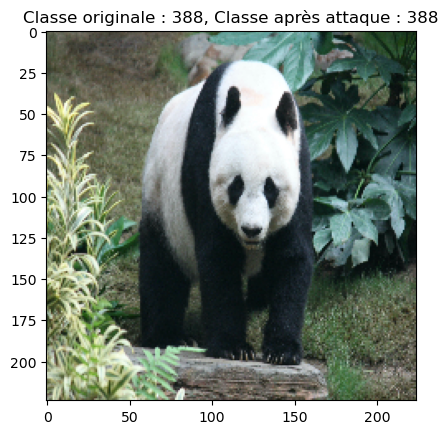

In [8]:
# Fonction pour effectuer une attaque d'un pixel
def one_pixel_attack(image, label, model, num_pixels=1):
    image = preprocess(image)
    image_probs = model.predict(image)
    original_prediction = np.argmax(image_probs)

    pixels_to_change = np.random.choice(range(224 * 224 * 3), num_pixels, replace=False)
    
    # Copier le tensor pour le modifier
    image = tf.identity(image)

    for pixel in pixels_to_change:
        row = pixel // (224 * 3)
        col_channel = pixel % (224 * 3)
        col = col_channel // 3
        channel = col_channel % 3

        # Perturber le pixel
        image = tf.tensor_scatter_nd_update(image, indices=[[0, row, col, channel]], updates=[np.random.uniform(0, 1)])

    # Vérifier la prédiction après l'attaque
    image_probs_after_attack = model.predict(image)
    attack_prediction = np.argmax(image_probs_after_attack)

    return original_prediction, attack_prediction

# Effectuer une attaque d'un pixel
original_class, attack_class = one_pixel_attack(img_array, None, pretrained_model)

# Afficher les résultats
plt.figure()
plt.imshow(img)
plt.title(f"Classe originale : {original_class}, Classe après attaque : {attack_class}")
plt.show()

## Exercice 3 :

1/1 [==============================] - 0s 28ms/step


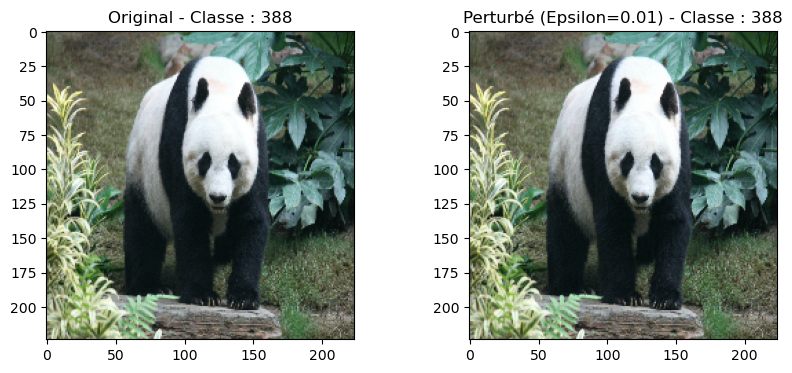

1/1 [==============================] - 0s 29ms/step


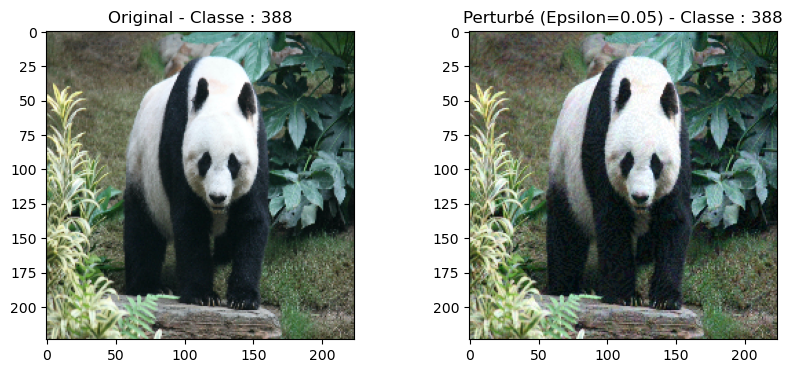

1/1 [==============================] - 0s 29ms/step


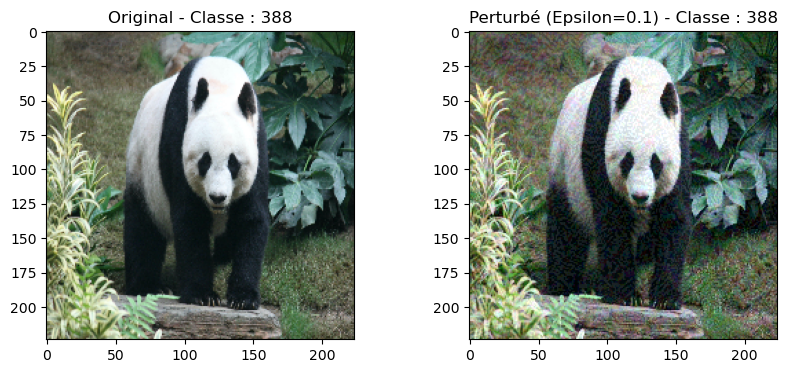

1/1 [==============================] - 0s 29ms/step


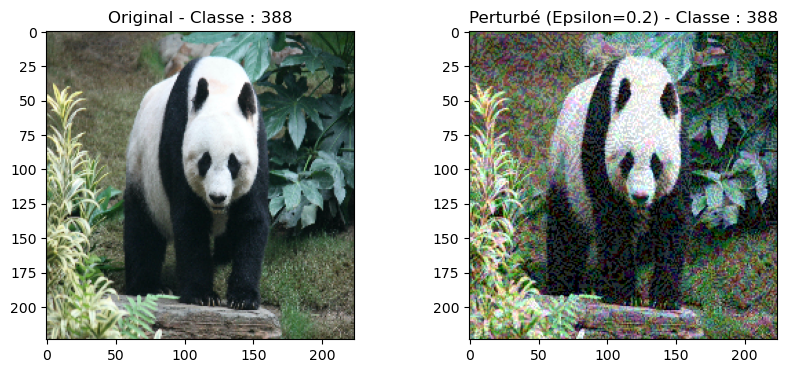

1/1 [==============================] - 0s 29ms/step


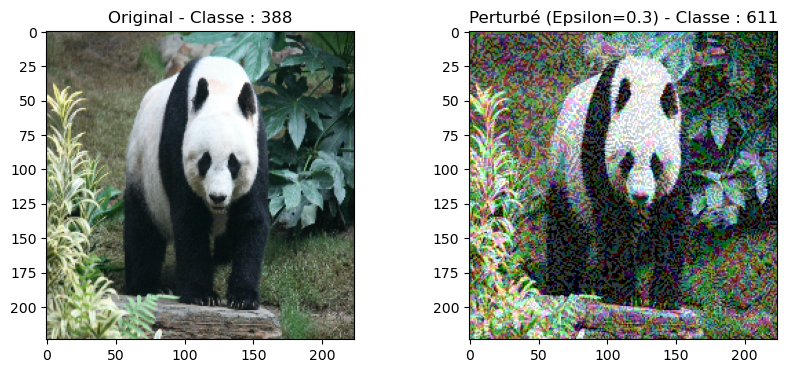

In [9]:
# Fonction pour effectuer une attaque FGSM
def fgsm_attack(image, label, model, epsilon):
    image = preprocess(image)
    image_probs = model.predict(image)
    original_prediction = np.argmax(image_probs)

    # Calculer la perte de cross-entropy
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    true_label = tf.one_hot(original_prediction, len(image_probs[0]))
    true_label = tf.reshape(true_label, (1, len(image_probs[0])))  # Ajuster la forme

    # Calculer le gradient de la perte par rapport à l'image d'entrée
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = loss_object(true_label, prediction)

    gradient = tape.gradient(loss, image)

    # Perturber l'image avec FGSM
    perturbed_image = image + epsilon * tf.sign(gradient)
    perturbed_image = tf.clip_by_value(perturbed_image, -1, 1)  # Ajuster à l'intervalle [-1, 1]

    # Normaliser l'image perturbée pour l'affichage dans la plage [0, 1]
    perturbed_image_for_display = (perturbed_image + 1) / 2

    # Normaliser l'image d'origine pour l'affichage dans la plage [0, 1]
    original_image_for_display = (image + 1) / 2

    # Vérifier la prédiction après l'attaque
    perturbed_probs = model.predict(perturbed_image)
    perturbed_prediction = np.argmax(perturbed_probs)

    return original_prediction, perturbed_prediction, original_image_for_display.numpy()[0], perturbed_image_for_display.numpy()[0]

# Tester différentes valeurs d'Epsilon
epsilons = [0.01, 0.05, 0.1, 0.2, 0.3]

for epsilon in epsilons:
    original_class, perturbed_class, original_image, perturbed_image = fgsm_attack(img_array, None, pretrained_model, epsilon)

    # Afficher les résultats
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title(f"Original - Classe : {original_class}")

    plt.subplot(1, 2, 2)
    plt.imshow(perturbed_image)
    plt.title(f"Perturbé (Epsilon={epsilon}) - Classe : {perturbed_class}")

    plt.show()

En augmentant Epsilon dans l'attaque FGSM, la perturbation appliquée à l'image devient plus prononcée. Une faible perturbation donne une image perturbée similaire à l'originale, tandis qu'une perturbation élevée peut rendre l'image irréconnaissable. Malgré cela, le modèle peut persister à prédire de manière incorrecte avec confiance, illustrant la sensibilité des modèles aux attaques adverses et leur propension à mal généraliser face à des perturbations subtiles.

## Exercice 4 :

In [10]:
# Convertir l'image en format compatible avec Foolbox
img_for_attack = tf.keras.applications.mobilenet_v2.preprocess_input(img_array[None, ...])

# Choisissons une classe cible différente de la prédiction réelle
target_class = 10  # Modifier cela en fonction de la classe cible souhaitée

# Obtenir la prédiction initiale
original_class = np.argmax(pretrained_model.predict(img_for_attack))

# Créer le modèle pour Foolbox
fmodel = foolbox.models.TensorFlowModel(pretrained_model, bounds=(0, 255))

# Créer une instance de l'attaque DeepFool
attack = foolbox.attacks.DeepFoolAttack()

# Effectuer l'attaque DeepFool avec classe cible
adversarial_image = attack(fmodel, img_for_attack[0], label=target_class)

# Afficher les résultats
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_array / 255.0)
plt.title("Image d'origine (Classe initiale : {})".format(original_class))

plt.subplot(1, 2, 2)
plt.imshow(adversarial_image.squeeze())
plt.title("Image perturbée par DeepFool (Classe cible : {})".format(target_class))

plt.show()

1/1 [==============================] - 0s 31ms/step
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


AttributeError: module 'foolbox.attacks' has no attribute 'DeepFoolAttack'